# Load Libraries & Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('https://raw.githubusercontent.com/youronlydimwit/Data_ScienceUse_Cases/main/Predictions/Data/Digital_Marketing_Report.xlsx')
df.head()

,Impressions,Reach,Video_plays,Link_clicks,Engagement,Live_time,Amount_spent
0,950185,864668,786848,11226,168,9,254775099
1,841657,774324,712378,23288,116,7,125741855
2,763610,733066,674421,30272,151,6,112957410
3,760239,691817,629553,32309,485,6,111369556
4,705633,663295,603598,6788,102,7,122996874


# Features in this dataset
This is a self-generated data, with the intent to predict the amount of money (in IDR) spent if we wanted to achieve said parameters / metrics in digital marketing campaign.
- `Impressions`: How many times our content is displayed
- `Reach`: How many users saw our content
- `Video_plays`: How many users clicked on our content
- `Link_clicks`: How many users clicked on our web and/or product links
- `Engagement`: How many comments users submitted on our content
- `Live time`: The amount of time our content is displayed on a campaign (days)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Impressions   100 non-null    int64
 1   Reach         100 non-null    int64
 2   Video_plays   100 non-null    int64
 3   Link_clicks   100 non-null    int64
 4   Engagement    100 non-null    int64
 5   Live_time     100 non-null    int64
 6   Amount_spent  100 non-null    int64
dtypes: int64(7)
memory usage: 5.6 KB


# Running Exploratory Data Analysis

Firstly we will try to inspect the data whether it has linearity or not before feeding it into our models later.

In [4]:
# Independent Columns to be tested
cols = ['Impressions', 'Reach', 'Video_plays', 'Link_clicks', 'Engagement', 'Live_time']

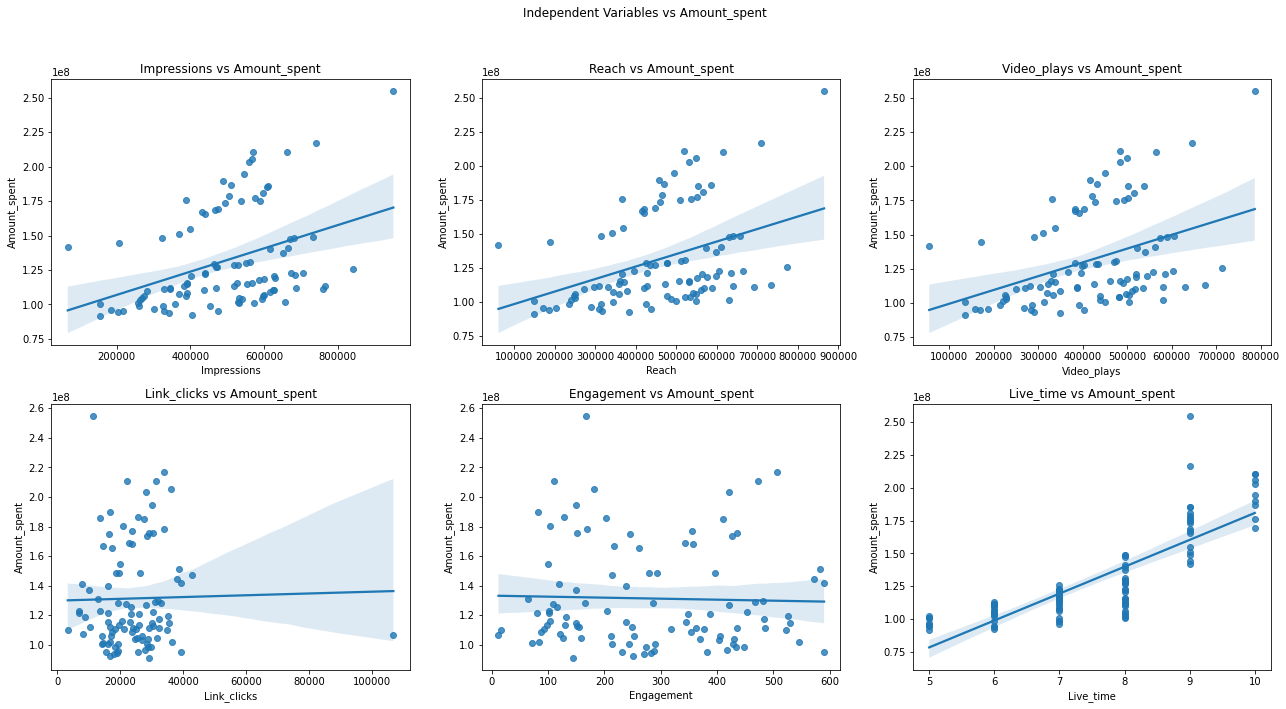

In [5]:
# Figure for visual inspection subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Independent Variables vs Amount_spent')

# Flatten axes 
axes = axes.flatten()

# Loop through each independent variable and plot the regression plot with confidence intervals
for i, column in enumerate(cols):
    sns.regplot(ax=axes[i], x=df[column], y=df['Amount_spent'], ci=95)
    axes[i].set_title(f'{column} vs Amount_spent')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the title
plt.show()

From this visual inspection alone, some features are not linear against our dependent variable, which are `Link_clicks`, and `Engagement`. We will inspect it further.

<AxesSubplot:>

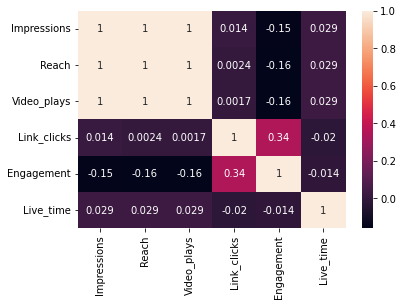

In [6]:
# Run heatmap correlation for Multicollinearity check
sns.heatmap(df[cols].corr(), annot=True)

There exists multicollinearity in the dataset. Since we only have 100 rows of data, and with the minimum amount of features, we can avoid excessive pruning and transformation, and feed this data into a robust model, `Random Forest` model.

# Running the Model

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# Specify X and Y variables
X = df[['Impressions', 'Reach', 'Video_plays', 'Link_clicks', 'Engagement', 'Live_time']]
y = df['Amount_spent']

# Split the data into Training and Testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train with Random Forest
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# Predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluation for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

Random Forest Regressor Performance:
Mean Squared Error: 229530977770136.81
R-squared: 0.86


**The Random Forest model explains 86% of the variance** in `Amount_spent`, an arguably decent results for a non-linear dataset. We will see what contributes most towards determining the `Amount_spent`.

       Feature  Importance
5    Live_time    0.809876
0  Impressions    0.063705
1        Reach    0.055954
2  Video_plays    0.053740
3  Link_clicks    0.010183
4   Engagement    0.006543


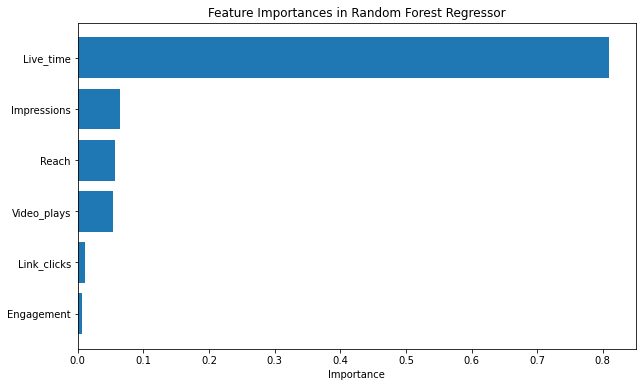

In [11]:
# Check Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Regressor')
plt.gca().invert_yaxis()
plt.show()

We can see that the `Live_time` variable is the most influential feature in this trained model, at 80%. After this, we can try to see results with different numbers set up for prediction.

# Dummy Data for Testing

In [14]:
# Initialize
data = {
    'Impressions': [400000, 370000, 180000],
    'Reach': [340000, 200000, 160000],
    'Video_plays': [120000, 100000, 78000],
    'Link_clicks': [11000, 14500, 13000],
    'Engagement': [800, 560, 1200],
    'Live_time': [7, 4, 10]
}

# Convert to DataFrame
test_df = pd.DataFrame(data)
test_df.head()

,Impressions,Reach,Video_plays,Link_clicks,Engagement,Live_time
0,400000,340000,120000,11000,800,7
1,370000,200000,100000,14500,560,4
2,180000,160000,78000,13000,1200,10


In [16]:
# Feed this data to our trained model
dummy_pred = rf_model.predict(test_df)

In [18]:
# Put in the test_df
test_df['Predicted_Amount_spent'] = [f"{int(pred):,}" for pred in dummy_pred]
test_df.head()

,Impressions,Reach,Video_plays,Link_clicks,Engagement,Live_time,Predicted_Amount_spent
0,400000,340000,120000,11000,800,7,"105,289,945"
1,370000,200000,100000,14500,560,4,"96,073,254"
2,180000,160000,78000,13000,1200,10,"151,741,761"


And there you have it! The amount of money predicted to be spent, in IDR, with Random Forest Model.